In [72]:
from mongo import MongoDBReader

db = MongoDBReader()

In [73]:
user_feedbacks = db.get_recommendation_feedbacks()


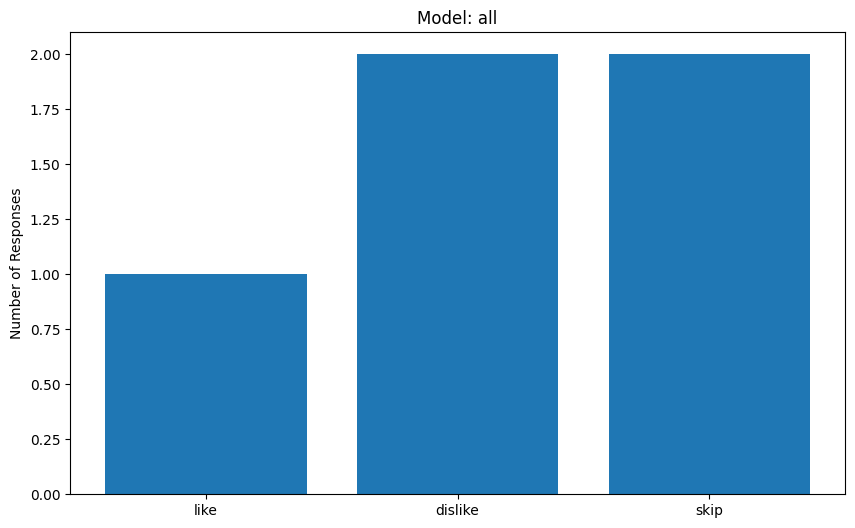

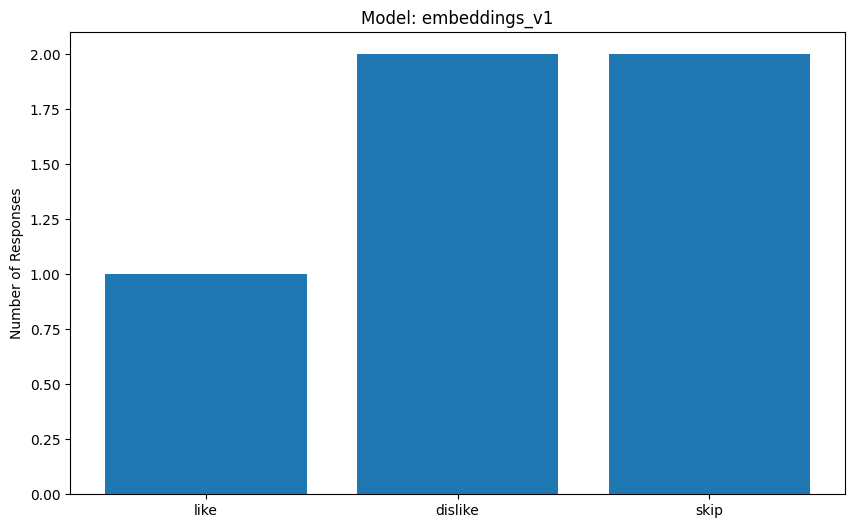

In [74]:
import matplotlib.pyplot as plt

user_feedbacks = db.get_recommendation_feedbacks()

# Count likes and dislikes and skips
models = {}
for feedback in user_feedbacks:
    if feedback['model'] not in models:
        models[feedback['model']] = {"like": 0, "dislike": 0, "skip": 0}
    if feedback['action'] == "like":
        models[feedback['model']]["like"] += 1
    elif feedback['action'] == "dislike":
        models[feedback['model']]["dislike"] += 1
    elif feedback['action'] == "skip":
        models[feedback['model']]["skip"] += 1

all_models = {
    "like": sum([models[model]["like"] for model in models]),
    "dislike": sum([models[model]["dislike"] for model in models]),
    "skip": sum([models[model]["skip"] for model in models])
}

def plot_model_feedback_distribution(like, dislike, skip, model):
    # Create bar plot
    plt.figure(figsize=(10,6))
    plt.bar(['like', 'dislike', 'skip'], [like, dislike, skip])
    plt.title('Model: ' + model)
    plt.ylabel('Number of Responses')
    plt.show()

# now for all models together
plot_model_feedback_distribution(all_models["like"], all_models["dislike"], all_models["skip"], "all")

for model in models:
    plot_model_feedback_distribution(models[model]["like"], models[model]["dislike"], models[model]["skip"], model)



<Figure size 1000x600 with 0 Axes>

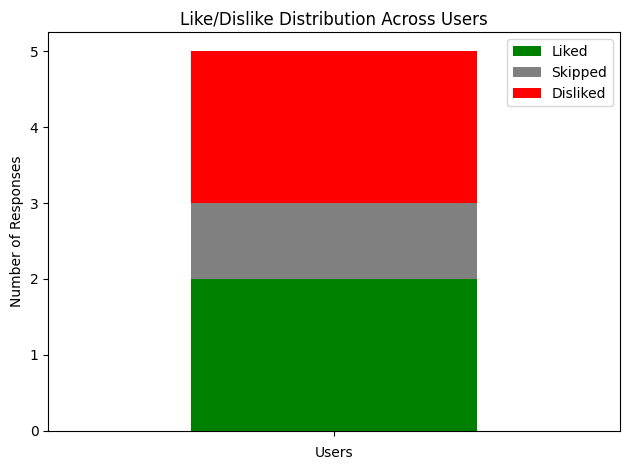

<Figure size 1000x600 with 0 Axes>

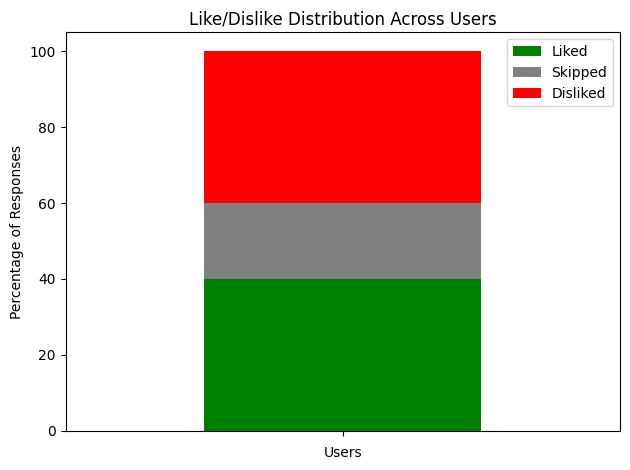

In [75]:
import pandas as pd

user_feedbacks = db.get_recommendation_feedbacks()


# Convert feedback data to DataFrame format
feedback_data = []
for feedback in user_feedbacks:
    feedback_data.append({
        'user_id': feedback['user_id'],
        'action': feedback['action']
    })
df = pd.DataFrame(feedback_data)

# Group by user_id and count actions
user_stats = df.groupby('user_id')['action'].value_counts().unstack(fill_value=0)

# Ensure both True and False columns exist
if True not in user_stats.columns:
    user_stats[True] = 0
if False not in user_stats.columns:
    user_stats[False] = 0


def plot_like_dislike_distribution(user_stats, relative=False):
    # Create stacked bar chart
    plt.figure(figsize=(10,6))
    
    if relative:
        # Convert to percentages
        plot_data = user_stats.div(user_stats.sum(axis=1), axis=0) * 100
        ylabel = 'Percentage of Responses'
    else:
        plot_data = user_stats
        ylabel = 'Number of Responses'
    
    # Sort by percentage of likes (ascending)
    like_percentages = user_stats[True] / user_stats.sum(axis=1)
    plot_data = plot_data.iloc[like_percentages.argsort()]
        
    plot_data.plot(kind='bar', stacked=True, color=['green', 'grey', 'red'])
    plt.title('Like/Dislike Distribution Across Users')
    plt.xlabel('Users')
    plt.ylabel(ylabel)
    plt.legend(['Liked', 'Skipped', 'Disliked'])
    plt.xticks(range(len(user_stats.index)), [''] * len(user_stats.index), rotation=0)
    plt.tight_layout()
    plt.show()

plot_like_dislike_distribution(user_stats)
plot_like_dislike_distribution(user_stats, relative=True)